# Pitchfork Word2Vec Demo

In [1]:
from nltk.tokenize import word_tokenize

import matplotlib
import numpy as np
import string
import tensorflow as tf
import time

## Import Raw Text File

In [2]:
import re
with open('reviews_corpus.txt', 'r', encoding='UTF-8') as f:
    text = f.read()

regex = re.compile(u"INSERT INTO content VALUES\(\d+,\'|\'\);|[^a-zA-Z_]")
text = re.sub(regex, ' ', text)

print(text[:500])

  Trip hop  eventually became a    s punchline  a music press shorthand for  overhyped hotel lounge music   But today  the much maligned subgenre almost feels like a secret precedent  Listen to any of the canonical Bristol scene albums of the mid late    s  when the genre was starting to chafe against its boundaries  and you d think the claustrophobic  anxious   st century started a few years ahead of schedule  Looked at from the right angle  trip hop is part of an unbroken chain that runs from 


In [5]:
from nltk.corpus import stopwords

def clean_text(text):
    stops = set(stopwords.words('english'))
    stops.add('r')
    stops.add('n')

    cleaned_text = text.lower()
    cleaned_text = word_tokenize(cleaned_text)
    cleaned_text = [word for word in cleaned_text if word not in stops]
                
    return cleaned_text

cleaned_text = clean_text(text)
print(cleaned_text[:500])

['trip', 'hop', 'eventually', 'became', 'punchline', 'music', 'press', 'shorthand', 'overhyped', 'hotel', 'lounge', 'music', 'today', 'much', 'maligned', 'subgenre', 'almost', 'feels', 'like', 'secret', 'precedent', 'listen', 'canonical', 'bristol', 'scene', 'albums', 'mid', 'late', 'genre', 'starting', 'chafe', 'boundaries', 'think', 'claustrophobic', 'anxious', 'st', 'century', 'started', 'years', 'ahead', 'schedule', 'looked', 'right', 'angle', 'trip', 'hop', 'part', 'unbroken', 'chain', 'runs', 'abrasion', 'post', 'punk', 'ruminative', 'pop', 'b', 'dance', 'fusion', 'moment', 'best', 'aged', 'far', 'gracefully', 'forcefully', 'anything', 'recorded', 'waning', 'days', 'record', 'industry', 'pre', 'filesharing', 'monomania', 'right', 'tricky', 'rebelled', 'attached', 'hip', 'scene', 'already', 'looking', 'shed', 'decamped', 'jamaica', 'record', 'aggressive', 'bristling', 'energy', 'mutation', 'style', 'name', 'pre', 'millennium', 'tension', 'obvious', 'thing', 'tells', 'two', 'decade

In [6]:
print("Total words: {}".format(len(cleaned_text)))
print("Total unique words: {}".format(len(set(cleaned_text))))

Total words: 7101903
Total unique words: 120786


In [7]:
import random

from collections import Counter

def build_dataset(cleaned_text, vocab_size=30000):
    '''
       Create mappings of data to their counts and indexes.
       
       Dictionary: n most common words including the 'UNK' token mapped to
       their integer id value in the dataset.

       Indexes: A dictionary mapping ids to vocabulary words in order to
       translate tensors back into words.

       Data: A translation of the whole text into integer values.

       Count: A list of n most common word tokens paired with their total
       number of occurences in the cleaned text.
    '''   
    count = [['<UNK>', 0]]
    count.extend(Counter(cleaned_text).most_common(vocab_size - 1))
       
    dictionary = dict()
    indexes = dict()
    for i in range(1, len(count)):
        dictionary[count[i][0]] = i
        indexes[i] = count[i][0]

    dictionary['<UNK>'] = 0
    indexes[0] = '<UNK>'
    data = list()
    for word in cleaned_text:
        if word not in dictionary:
            count[0][1] += 1
        else:
            data.append(dictionary[word])

    return data, count, dictionary, indexes

In [8]:
data, count, dictionary, indexes = build_dataset(cleaned_text)

print(data[:50], '\n')
print(count[:50], '\n')

[881, 188, 650, 777, 5574, 4, 1069, 9011, 2165, 2677, 4, 670, 15, 11023, 8039, 62, 99, 1, 1354, 6007, 265, 9466, 9285, 297, 82, 345, 214, 270, 1189, 3079, 154, 3628, 3704, 957, 760, 662, 37, 1371, 7001, 2772, 103, 3608, 881, 188, 98, 14154, 2305, 991, 12153, 132] 

[['<UNK>', 290946], ('like', 67129), ('album', 45753), ('one', 37779), ('music', 36304), ('band', 33099), ('songs', 28032), ('song', 25762), ('even', 24463), ('sound', 24116), ('rock', 20765), ('record', 20724), ('time', 20665), ('new', 20512), ('first', 18655), ('much', 18445), ('pop', 18154), ('track', 18059), ('guitar', 17810), ('two', 17567), ('sounds', 17116), ('way', 15956), ('tracks', 15906), ('still', 15887), ('though', 14038), ('also', 13785), ('could', 13619), ('well', 13013), ('would', 13006), ('best', 12959), ('back', 12811), ('work', 12696), ('make', 12225), ('love', 12171), ('get', 12125), ('something', 12087), ('never', 12012), ('years', 11783), ('little', 11702), ('good', 11170), ('might', 10903), ('replace',

In [9]:
def subsample(data):
    '''
       Subsample data in order to reduce more frequently
       occurring words.
    '''
    t = 1e-5
    
    frequencies = Counter(data)
    frequencies = {key: value/len(data) for key, value in frequencies.items()}
    drop_probability = {key: np.sqrt((t/frequencies[key])) for key in frequencies.keys()}
    input_data = [word for word in data if random.random() < 1 - drop_probability[word]]
 
    return input_data

In [10]:
input_data = subsample(data)

print(input_data[:50])

[188, 650, 777, 4, 1069, 9011, 2165, 2677, 4, 670, 15, 8039, 62, 99, 1, 265, 297, 82, 345, 1189, 154, 957, 760, 662, 37, 7001, 2772, 103, 3608, 881, 188, 98, 991, 132, 107, 16, 159, 135, 187, 29, 3619, 112, 4677, 152, 155, 262, 11, 1466, 936, 103]


In [11]:
def get_context_words(words, sample_number):
    '''
       Select random set of sample_number words to obtain
       context for the skip-gram model.
    '''
    return [random.choice(words) for i in range(sample_number)]

In [12]:
def batchify(input_data, context_window, sample_number, batch_size):
    '''
       Splits data into batches of size batch_size, which are ndarrays
       containing words with some associated context words drawn from
       the context_window on either side. sample_number is the
       number of context words to pull before shifting the context_window.
    '''
    n_batches = len(input_data) // batch_size
    train_inputs = input_data[:n_batches*batch_size]
    
    for i in range(0, len(train_inputs), batch_size):
        inputs, labels = [], []
        batch = train_inputs[i:i+batch_size]
        
        for j in range(len(batch)):
            target = batch[j]
            if j < context_window + 1:
                context = get_context_words(batch[max(0, j-1):j] + batch[j+1:context_window], sample_number)
            else:
                context = get_context_words(batch[j-context_window:j] + batch[j+1:context_window], sample_number)
            
            labels.extend(context)
            inputs.extend([target] * sample_number)

        yield inputs, labels

In [13]:
embedding_size = 300
num_sampled = 100
vocab_size = 50000

graph = tf.Graph()
with graph.as_default():
    # Create placeholder tensors for input and context training values.
    inputs = tf.placeholder(tf.int32, shape=[None])
    labels = tf.placeholder(tf.int32, shape=[None, None])
    
    # Create a vocab_size x embedding_size matrix of randomly distributed
    # values between -1 and 1. embed_lookup acts as indexing reference
    # for inputs
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    embed_lookup = tf.nn.embedding_lookup(embeddings, inputs)
    
    # Initialize weights and biases for training
    weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size]))
    biases = tf.Variable(tf.zeros([vocab_size]))
    
    # Train weights and biases with Noise Contrastive Estimation
    # loss.
    loss = tf.nn.nce_loss(
        weights=weights,
        biases=biases,
        inputs=embed_lookup,
        labels=labels,
        num_sampled=num_sampled,
        num_classes=vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [14]:
sample_size = 20

with graph.as_default():
    # Select sample words for validation in ranges 0-100 and 1000-1100 by id and place in a tensor.
    common_words = [count[i][0] for i in range(1, num_sampled + 1)] + [count[j][0] for j in range(1000, (1001+num_sampled))]
    common_words = [dictionary[word] for word in common_words]
    
    cv_samples = np.random.choice(common_words, size=sample_size, replace=False)
    cv_data = tf.constant(cv_samples, dtype=tf.int32)
    
    normalize = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    norm_embed = embeddings / normalize

    cv_embed = tf.nn.embedding_lookup(norm_embed, cv_data)
    similarity = tf.matmul(cv_embed, tf.transpose(norm_embed))

In [15]:
batch_size = 1000
epochs = 15
context_window = 10
sample_number = 5

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    average_loss = 0
    iteration = 1
    sess.run(tf.global_variables_initializer())

    for epoch in range(1, epochs+1):
        start_time = time.time()
        batches = batchify(input_data, context_window, sample_number, batch_size)        

        for train_inputs, train_labels in batches:
            feed_dict = {inputs: train_inputs, labels: np.array(train_labels)[:, None]}
            _, loss = sess.run([optimizer, cost], feed_dict=feed_dict)
            average_loss += loss

            if iteration % 1000 == 0:
                if iteration > 0:
                    end_time = time.time()
                    print('Epoch {}/{}'.format(epoch, epochs))
                    print('Iteration is {}'.format(iteration))
                    print('Average loss is {}'.format(average_loss/1000))
                    print('Loss is {}'.format(loss))
                    print('Time per batch is {} mins'.format((end_time-start_time)/60))
                    start_time = time.time()
                    average_loss = 0
            if iteration % 5000 == 0:
                sim = similarity.eval()
                for i in range(20):
                    valid_word = indexes[cv_samples[i]]
                    neighbors = 8
                    nearest = (-sim[i, :]).argsort()[1:neighbors + 1]
                    output = "Closest words to {} are".format(valid_word)
                    for k in range(neighbors):
                        close_word = indexes[nearest[k]]
                        output = "{} {}".format(output, close_word)
                    print(output)
                    
            iteration += 1
           
    save_path = saver.save(sess, "checkpoints/pitchfork_embedding.ckpt")
    embed_mat = sess.run(norm_embed)

Epoch 1/15
Iteration is 1000
Average loss is 477.42893200683596
Loss is 341.083984375
Time per batch is 0.6482620596885681 mins
Epoch 1/15
Iteration is 2000
Average loss is 280.66381173706054
Loss is 189.82989501953125
Time per batch is 0.47784892717997235 mins
Epoch 1/15
Iteration is 3000
Average loss is 192.89939599609374
Loss is 196.2001190185547
Time per batch is 0.47717212041219076 mins
Epoch 1/15
Iteration is 4000
Average loss is 141.92323876190184
Loss is 102.53166198730469
Time per batch is 0.47669365008672077 mins
Epoch 2/15
Iteration is 5000
Average loss is 106.80653312683106
Loss is 59.46535110473633
Time per batch is 0.27517223358154297 mins
Closest words to distorted are well song make track still title sounds though
Closest words to debut are would like song two still band sound track
Closest words to people are one two track like band even first rock
Closest words to waiting are come would though one way even long like
Closest words to still are album even like sound tho

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

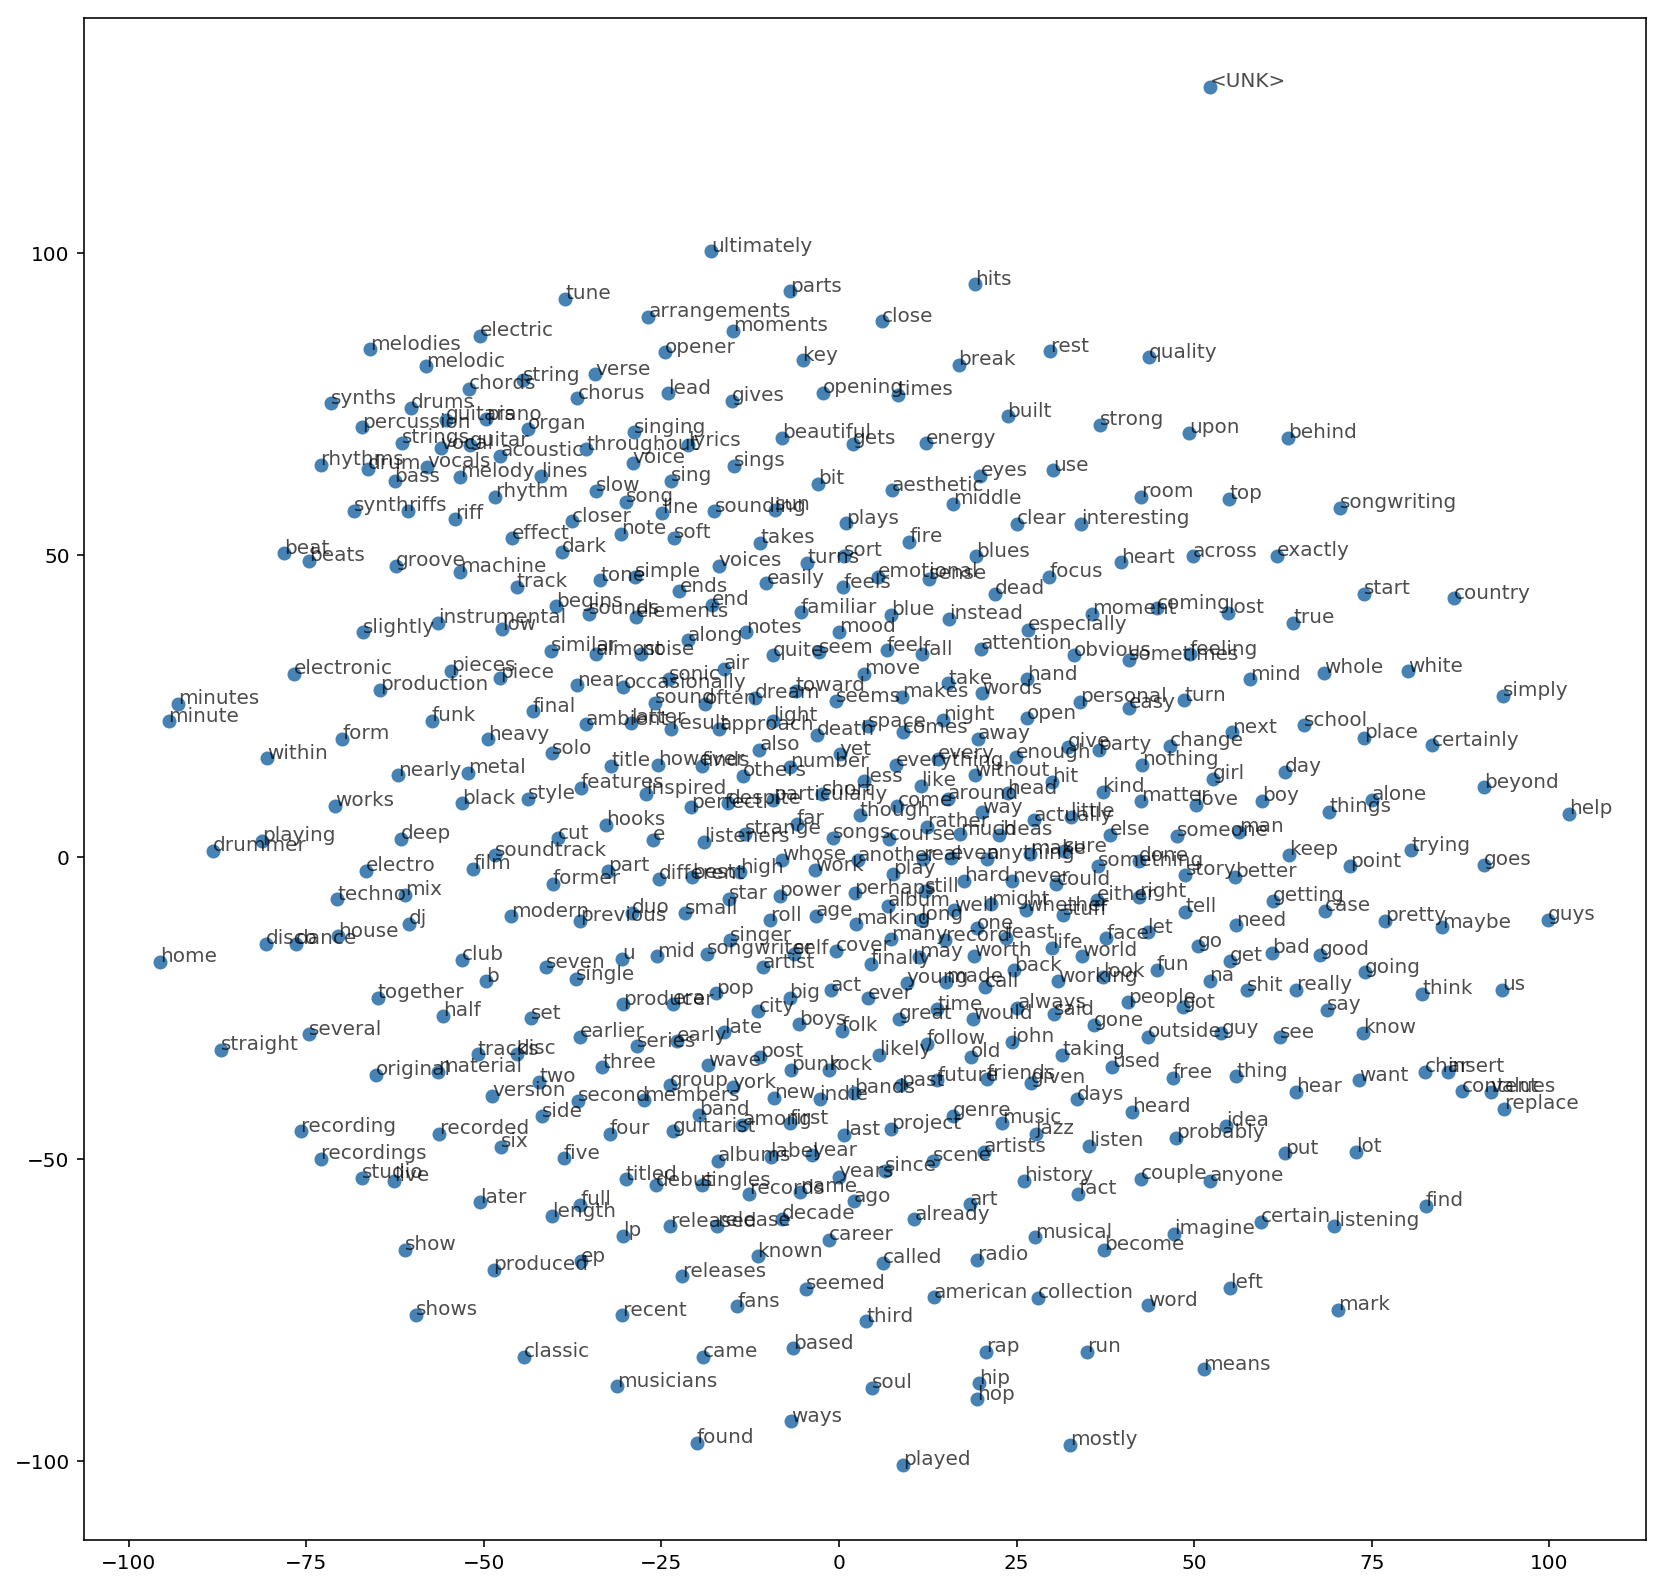

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
for i in range(viz_words):
    plt.scatter(*embed_tsne[i, :], color='steelblue')
    plt.annotate(indexes[i], (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)